### Build and test a Naive Bayes classifier using iris data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.naive_bayes import BernoulliNB

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

In [3]:
# Load the data, which is included in sklearn.
iris = load_iris()
print ('Iris target names:', iris.target_names)
print ('Iris feature names:', iris.feature_names)
X, Y = iris.data, iris.target

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
train_data, train_labels = X[:100], Y[:100]
test_data, test_labels = X[100:], Y[100:]

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


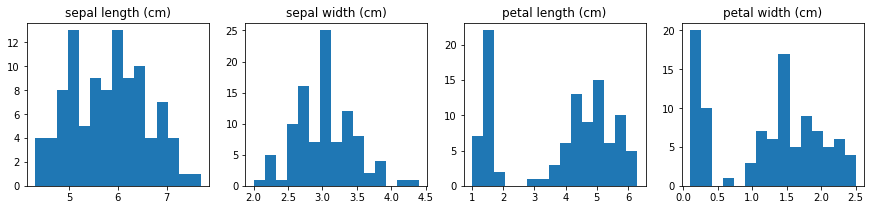

In [4]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(15, 3))

# For each feature of each data point, plot a histogram distribution
for feature in range(len(train_data[0])):
    plt.subplot(1, 4, feature+1)
    plt.hist(train_data[:,feature], bins=15)
    plt.title(iris.feature_names[feature])
    
plt.show()

### Binary features

Binarize the feature values into "short" and "long" so that we can decide whether the feature should be counted (1) or not (0) when creating the conditional probabilities.

In [7]:
# Define a function that applies a threshold to turn real valued iris features into 0/1 features.
# 0 will mean "short" and 1 will mean "long".
def binarize_iris(data, thresholds):
    
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.empty(data.shape)

    # Apply a threshold  to each feature and create a true/false (1/0) matrix
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data[:,feature] > thresholds[feature]
    return binarized_data

# Calculate the thresholds to binarize features into short and long using the mean
thresholds = [train_data[:,0].mean(), train_data[:,1].mean(), train_data[:,2].mean(), train_data[:,3].mean()]

# Create new binarized training and test data
binarized_train_data = binarize_iris(train_data, thresholds)
binarized_test_data = binarize_iris(test_data, thresholds)

### Create the Naive Bayes class

In [98]:
class NaiveBayes:
    
    # Initialize an instance of the class.
    def __init__(self, alpha=1.0):
        self.alpha = alpha     # additive (Laplace) smoothing parameter (prior count starts at alpha)
        self.priors = None     # estimated by fit()
        self.probs = None      # estimated by fit()
        self.num_labels = 0    # set by fit()
        self.num_features = 0  # set by fit()
        
    def fit(self, train_data, train_labels):
        # Store number of labels, number of features, and number training examples.
        self.num_labels = len(np.unique(train_labels))
        self.num_features = train_data.shape[1]
        self.num_examples = train_data.shape[0]
        
        # Initialize an array of label counts. Each label gets a smoothed count of 2*alpha because
        # each feature value (0 and 1) gets an extra count of alpha.
        label_counts = np.ones(self.num_labels) * self.alpha * 2

        # Initialize an array of (feature=long, label) counts to alpha.
        feature1_and_label_counts = np.ones([self.num_features, self.num_labels]) * self.alpha
        
        # Count up the labels and the number of long features for that label
        for data_point, label in zip(train_data, train_labels):
            label_counts[label] += 1
            feature1_and_label_counts[:,label] += data_point

        # Normalize to get probabilities P(feature=1|label).
        self.probs = feature1_and_label_counts / label_counts
        
        # Normalize label counts to get prior probabilities P(label).
        self.priors = label_counts / label_counts.sum()
        

    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return np.array(results)
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        # Make a copy of the prior probabilities.
        predictions = self.priors.copy()
        
        # Multiply by each conditional feature probability.
        
        for (index, value) in enumerate(item):
            feature_probs = self.probs[index]
            if not value: 
                feature_probs = 1 - feature_probs
            predictions *= feature_probs
            

        # Normalize and return the label that gives the largest probability.
        predictions /= predictions.sum()
        return predictions.argmax()

### Test the class

In [103]:
alpha = 0.5
nb = NaiveBayes(alpha=alpha)
nb.fit(binarized_train_data, train_labels)

In [104]:
# Compute accuracy on the test data.
preds = nb.predict(binarized_test_data)
correct, total = 0, 0

for pred, label in zip(preds, test_labels):
    if pred == label: 
        correct += 1
    total += 1
    
print ('With alpha = %.2f' %alpha)
print ('[OUR implementation] total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, correct/total))

# Compare to sklearn's implementation.
clf = BernoulliNB(alpha=alpha)
clf.fit(binarized_train_data, train_labels)
print ('sklearn accuracy: %3.2f' %clf.score(binarized_test_data, test_labels))

print ('\nOur feature probabilities\n', nb.probs)
print ('\nsklearn feature probabilities\n', np.exp(clf.feature_log_prob_).T)

print ('\nOur prior probabilities\n', nb.priors)
print ('\nsklearn prior probabilities\n', np.exp(clf.class_log_prior_))

With alpha = 0.50
[OUR implementation] total:  50  correct:  38  accuracy: 0.76
sklearn accuracy: 0.76

Our feature probabilities
 [[0.015625   0.54411765 0.85135135]
 [0.796875   0.19117647 0.31081081]
 [0.015625   0.83823529 0.98648649]
 [0.015625   0.69117647 0.98648649]]

sklearn feature probabilities
 [[0.015625   0.54411765 0.85135135]
 [0.796875   0.19117647 0.31081081]
 [0.015625   0.83823529 0.98648649]
 [0.015625   0.69117647 0.98648649]]

Our prior probabilities
 [0.31067961 0.33009709 0.3592233 ]

sklearn prior probabilities
 [0.31 0.33 0.36]
